# Project

__[Project Page](https://notes.teklia.com/s/AU3AEfOBr#)__

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
firstname_with_sex = pd.read_csv('firstname_with_sex.csv', sep=';')
transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=',')
#transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=';|:')

In [116]:
# A ratio closer to 1 means a name more used by males
firstname_with_sex['total_count'] = firstname_with_sex.male + firstname_with_sex.female
firstname_with_sex['ratio'] = firstname_with_sex['male'] / (firstname_with_sex['male'] + firstname_with_sex['female'])

In [117]:
firstname_with_sex

,firstname,male,female,ratio,total_count
0,marie,10145,2390322,0.004226,2400467
1,jean,1869615,6476,0.996548,1876091
2,pierre,1475841,5047,0.996592,1480888
3,jeanne,1765,1097397,0.001606,1099162
4,françois,1089009,5951,0.994565,1094960
...,...,...,...,...,...
6941,winnocq,10,0,1.000000,10
6942,xyste,9,1,0.900000,10
6943,zara,0,10,0.000000,10
6944,zéraphin,10,0,1.000000,10


In [5]:
firstname_with_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   object
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.9+ KB


In [212]:
transcriptions_with_sex

,subject_line,groundtruth,prediction,sex,groundtruth_length,prediction_length
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,71,65
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,74,88
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,83,56
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,74,86
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,45,82
...,...,...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme,93,95
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme,77,100
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme,91,87
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme,73,69


### Descriptive Statistics

<AxesSubplot:>

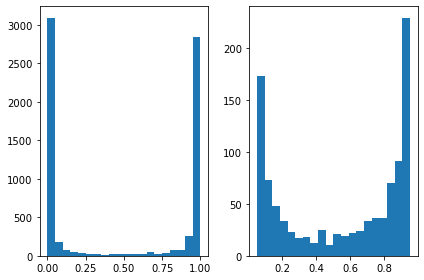

In [8]:
fig, ax = plt.subplots(1, 2, sharey=False, tight_layout=True)

ax[0].hist(firstname_with_sex['ratio'], bins=20)
ax[1].hist(firstname_with_sex['ratio'], bins=20, range=(0.05, 0.95))
ax[0]

<AxesSubplot:>

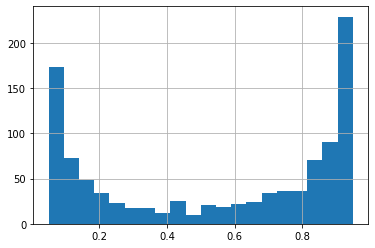

In [9]:
firstname_with_sex['ratio'].hist(bins=20, range=(0.05, 0.95),log=False)

In [29]:
attributes_list = ['surname', 'firstname', 'occupation', 'link', 'age', 'civil_status', 'birth_date', 'observation', 'employer']
attributes_list_doublepoint = ['surname:', 'firstname:', 'occupation:', 'link:', 'age:', 'civil_status:', 'birth_date:', 'observation:', 'employer:', 'lob:']

The groundtruth column contains multiple interesting information. We split it to obtain deeper understanding into the available data.

In [188]:
def key_value(s):
    key = None
    value = []
    for token in s.split():
        if token[-1] == ":":
            if key is not None:
                yield key, " ".join(value)
            key = token[:-1]
            value = []
        else:
            value.append(token)
    if key is not None:
        yield key, " ".join(value)

In [198]:
df = pd.DataFrame({key: value for key, value in key_value(string)} for string in transcriptions_with_sex.groundtruth)
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN


In [199]:
df['sex'] = transcriptions_with_sex.sex
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN,femme
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN,homme
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN,femme
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN,femme
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN,femme
...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN,femme
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN,homme
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN,femme
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN,homme


In [90]:
df_copy = df.fillna('', inplace=False)
df['combined'] = 'firstname: ' + df_copy['firstname'] + ', link: ' + df_copy['link'] + ', occupation: ' + df_copy['occupation']
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,combined
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN,femme,"firstname: Marie, link: fille, occupation: idem"
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN,homme,"firstname: Louis-Jean, link: chef, occupation: sp"
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN,femme,"firstname: Marie, link: idem, occupation: idem"
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN,femme,"firstname: Marie, link: femme, occupation:"
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN,femme,"firstname: Marguerite, link: , occupation:"
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN,femme,"firstname: Pétronille, link: épouse, occupatio..."
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN,homme,"firstname: Alexandre, link: son fils, occupati..."
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN,femme,"firstname: Marguerite, link: épouse, occupatio..."
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN,homme,"firstname: Etienne, link: fils, occupation:"


In [160]:
df.link.value_counts()

chef                   50
idem                   29
enfant                 23
femme                  19
fils                   17
épouse                 16
fille                  13
leur fils               5
domestique              4
sa femme                4
Chef                    3
bru                     3
belle-mère              3
ch. m                   3
mère de famille         2
petit-fils              2
frère                   2
Sa femme                2
chef de ménage          2
son fils                2
mère                    2
ép                      2
mére de famille         1
assisté de la S.        1
chef de famille         1
Schouer                 1
leur fille              1
ouvrier                 1
assisté                 1
sa brue                 1
Son fils                1
pensionnaire            1
ép e                    1
fils de la bonne        1
enf                     1
Leur fils               1
femme de chambre        1
domestique de ferme     1
petite-fille

In [161]:
df.firstname.value_counts()

Marie         28
Jean          19
Marguerite    10
Jeanne         9
Pierre         9
              ..
Emile          1
Stanislas      1
Gervais        1
Amélie         1
Pétronille     1
Name: firstname, Length: 92, dtype: int64

In [162]:
df.occupation.value_counts()

idem                  54
néant                 15
cultivateur           12
sp                    10
s.p                   10
                      ..
clerc de nptaire       1
quincaillier           1
charcutier             1
sellier                1
cultiv eur fermier     1
Name: occupation, Length: 70, dtype: int64

In [163]:
df.civil_status.value_counts()

Garçon         2
Homme marié    1
Name: civil_status, dtype: int64

In [164]:
df.employer.value_counts()

idem             14
patron           11
Labage            2
Troussière        2
Choussy           2
Lavocat           2
néant             2
Debord            1
Lavany            1
Margottas         1
Cie f re          1
Dubuisson         1
Chene             1
Lefebure          1
Goudier           1
Bonnichou         1
horticulteur      1
Chabet            1
Gouvernaire       1
Bruel             1
chemin de fer     1
Name: employer, dtype: int64

In [128]:
df_descriptive = pd.DataFrame()
df_descriptive['nan'] = df.isna().sum()
df_descriptive['ratio_nan'] = df_descriptive.nan / 241
df_descriptive

,nan,ratio_nan
surname,1,0.004149
firstname,1,0.004149
occupation,42,0.174274
link,11,0.045643
age,43,0.178423
employer,192,0.796680
birth_date,194,0.804979
lob,206,0.854772
civil_status,238,0.987552
observation,240,0.995851


In [150]:
df_descriptive.index.name = 'Features'
df_descriptive.reset_index(inplace=True)
df_descriptive

,Features,nan,ratio_nan
0,surname,1,0.004149
1,firstname,1,0.004149
2,occupation,42,0.174274
3,link,11,0.045643
4,age,43,0.178423
5,employer,192,0.796680
6,birth_date,194,0.804979
7,lob,206,0.854772
8,civil_status,238,0.987552
9,observation,240,0.995851


We only use the features 'surname', 'firstname', 'occupation', 'link', 'age' from the groundtruth, as the others have more than 75% of NaN values and are hence not suited for prediction tasks. The other columns also don't contain indicative information helpful for training a model, as indicated using the .value_counts() function

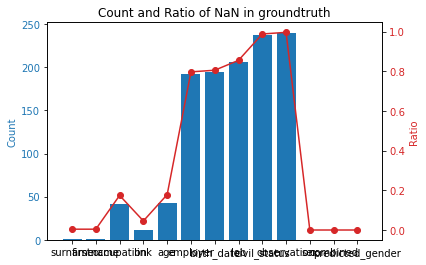

In [169]:
# Plot
fig, ax1 = plt.subplots()

# Bar plot
color = 'tab:blue'
#ax1.set_xlabel('Bla')
ax1.set_ylabel('Count', color=color)
ax1.bar(df_descriptive.Features, df_descriptive['nan'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Twin axes
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Ratio', color=color)
ax2.plot(df_descriptive.Features, df_descriptive['ratio_nan'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Title and labels
plt.title('Count and Ratio of NaN in groundtruth')
plt.xlabel('Feature')
plt.xticks(rotation=75)

# Display the plot
plt.show()

In [91]:
df_copy

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
0,Chardon,Marie,idem,fille,30,,,,,,femme
1,Lhopital,Louis-Jean,sp,chef,67,,,,,,homme
2,Papin,Marie,idem,idem,15,idem,,,,,femme
3,Lavocat,Marie,,femme,,,1875,Rigny,,,femme
4,Benne,Marguerite,,,78,,,,,,femme
...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,,,,,,femme
237,Combey,Alexandre,idem,son fils,39,,,,,,homme
238,Collin,Marguerite,idem,épouse,38,idem,,,,,femme
239,Dumont,Etienne,,fils,,,1900,idem,,,homme


In [64]:
transcriptions_with_sex

,subject_line,groundtruth,prediction,sex,groundtruth_length,prediction_length
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,71,65
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,74,88
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,83,56
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,74,86
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,45,82
...,...,...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme,93,95
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme,77,100
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme,91,87
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme,73,69


#### Transcriptions Descriptive Analysis

In [40]:
df.sex.value_counts()

homme     125
femme     107
ambigu      9
Name: sex, dtype: int64

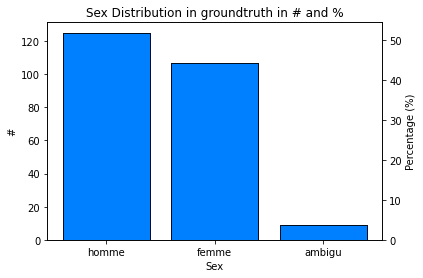

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Data
sex = ['homme', 'femme', 'ambigu']
counts = [125, 107, 9]

# Calculate total count
total_count = sum(counts)

# Calculate percentages
percentages = [(count / total_count) * 100 for count in counts]

# Create figure and axes
fig, ax1 = plt.subplots()

# Create bar plot for counts
color = 'black'
ax1.bar(sex, counts, color=np.linspace(0, 1, len(sex)), edgecolor=color)
ax1.set_xlabel('Sex')
ax1.set_ylabel('#', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create twin axes for percentages
ax2 = ax1.twinx()
color = 'black'
ax2.bar(sex, percentages, color=np.linspace(0, 1, len(sex)), alpha=0.5, edgecolor=color)
ax2.set_ylabel('Percentage (%)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding title
plt.title('Sex Distribution in groundtruth in # and %')

# Show plot
plt.show()

       groundtruth_length  prediction_length
count          241.000000         241.000000
mean            80.435685          88.099585
std             17.058142          20.820424
min             43.000000          43.000000
25%             71.000000          73.000000
50%             76.000000          85.000000
75%             86.000000          97.000000
max            144.000000         168.000000


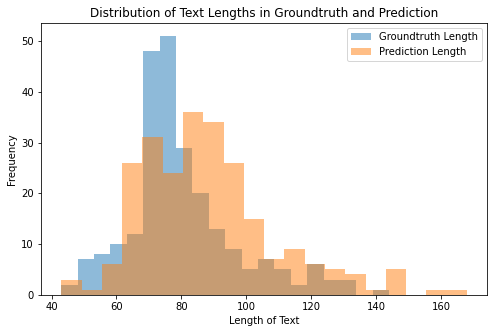

In [49]:
# Calculate the length of text in 'groundtruth' and 'prediction'
transcriptions_with_sex['groundtruth_length'] = transcriptions_with_sex['groundtruth'].apply(len)
transcriptions_with_sex['prediction_length'] = transcriptions_with_sex['prediction'].apply(len)

# Descriptive statistics for text lengths
print(transcriptions_with_sex[['groundtruth_length', 'prediction_length']].describe())

# Visualize the distribution of text lengths
plt.figure(figsize=(8, 5))
plt.hist(transcriptions_with_sex['groundtruth_length'], bins=20, alpha=0.5, label='Groundtruth Length')
plt.hist(transcriptions_with_sex['prediction_length'], bins=20, alpha=0.5, label='Prediction Length')
plt.title('Distribution of Text Lengths in Groundtruth and Prediction')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### First models

#### Text models

In [118]:
firstname_with_sex

,firstname,male,female,ratio,total_count
0,marie,10145,2390322,0.004226,2400467
1,jean,1869615,6476,0.996548,1876091
2,pierre,1475841,5047,0.996592,1480888
3,jeanne,1765,1097397,0.001606,1099162
4,françois,1089009,5951,0.994565,1094960
...,...,...,...,...,...
6941,winnocq,10,0,1.000000,10
6942,xyste,9,1,0.900000,10
6943,zara,0,10,0.000000,10
6944,zéraphin,10,0,1.000000,10


In [192]:
df_copy

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
0,Chardon,Marie,idem,fille,30,,,,,,femme
1,Lhopital,Louis-Jean,sp,chef,67,,,,,,homme
2,Papin,Marie,idem,idem,15,idem,,,,,femme
3,Lavocat,Marie,,femme,,,1875,Rigny,,,femme
4,Benne,Marguerite,,,78,,,,,,femme
...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,,,,,,femme
237,Combey,Alexandre,idem,son fils,39,,,,,,homme
238,Collin,Marguerite,idem,épouse,38,idem,,,,,femme
239,Dumont,Etienne,,fils,,,1900,idem,,,homme


In [190]:
# Function to determine predicted sex
def predict_sex(row):
    firstname = row['firstname'].lower()
    match = firstname_with_sex[firstname_with_sex['firstname'] == firstname]
    if len(match) > 0:
        if match['male'].iloc[0] > match['female'].iloc[0]:
            return 'homme'
        else:
            return 'femme'
    else:
        return None

In [193]:
# Apply function to create 'pred_sex' column
df_copy['pred_sex'] = df_copy.apply(predict_sex, axis=1)

df_copy

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,pred_sex
0,Chardon,Marie,idem,fille,30,,,,,,femme,femme
1,Lhopital,Louis-Jean,sp,chef,67,,,,,,homme,None
2,Papin,Marie,idem,idem,15,idem,,,,,femme,femme
3,Lavocat,Marie,,femme,,,1875,Rigny,,,femme,femme
4,Benne,Marguerite,,,78,,,,,,femme,femme
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,,,,,,femme,femme
237,Combey,Alexandre,idem,son fils,39,,,,,,homme,homme
238,Collin,Marguerite,idem,épouse,38,idem,,,,,femme,femme
239,Dumont,Etienne,,fils,,,1900,idem,,,homme,homme


In [195]:
#df_copy['pred_sex'] = df_copy.apply(predict_sex, axis=1)
correct_predictions = (df_copy['pred_sex'] == df_copy['sex']).sum()
total_predictions = len(df_copy)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.9128630705394191


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   surname           240 non-null    object
 1   firstname         240 non-null    object
 2   occupation        199 non-null    object
 3   link              230 non-null    object
 4   age               198 non-null    object
 5   employer          49 non-null     object
 6   birth_date        47 non-null     object
 7   lob               35 non-null     object
 8   civil_status      3 non-null      object
 9   observation       1 non-null      object
 10  sex               241 non-null    object
 11  combined          241 non-null    object
 12  predicted_gender  241 non-null    object
 13  name_found        241 non-null    bool  
dtypes: bool(1), object(13)
memory usage: 24.8+ KB


In [197]:
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN


In [200]:
df_drop = df.loc[df['sex'] == 'ambigu']
df_drop

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
17,Daniel,Claude,journalier,chef,33,NaN,NaN,NaN,NaN,NaN,ambigu
59,Gorbinet,Jeanne,idem,chef,66,NaN,NaN,NaN,NaN,NaN,ambigu
94,Roumeau,Claude,cultivateur,chef,30 ans,NaN,NaN,NaN,NaN,NaN,ambigu
123,Chardon,Marie,idem,chef,84 ans,NaN,NaN,NaN,NaN,NaN,ambigu
124,Grillé,Emile,idem,idem,2,idem,NaN,NaN,NaN,NaN,ambigu
130,Martin,Marie,idem,idem,45,NaN,NaN,NaN,NaN,NaN,ambigu
196,Pénot,Claude,s.p,enfant,13,NaN,NaN,NaN,NaN,NaN,ambigu
204,Coq,Antonie,idem,idem,16,idem,NaN,NaN,NaN,NaN,ambigu
230,Clayeux,Claude,idem,idem,13,idem,NaN,NaN,NaN,NaN,ambigu


In [203]:
df_copy = df
df_copy

mask = (df_copy['sex'] == 'ambigu')

# Use the mask to drop the sub-dataframe
df_copy = df_copy.drop(df_copy[mask].index)
df_copy

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN,femme
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN,homme
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN,femme
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN,femme
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN,femme
...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN,femme
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN,homme
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN,femme
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN,homme


In [205]:
df_copy = df_copy.fillna('', inplace=False)
df_copy['pred_sex'] = df_copy.apply(predict_sex, axis=1)
correct_predictions = (df_copy['pred_sex'] == df_copy['sex']).sum()
total_predictions = len(df_copy)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.9482758620689655


Removing the 'ambigu' entries increases accuracy

In [208]:
# Create a new column to indicate correct or incorrect prediction
df_copy['correct_prediction'] = df_copy['pred_sex'] == df_copy['sex']

# Filter dataframe to show misclassified rows
misclassified_rows = df_copy[df_copy['correct_prediction'] == False]

print("Misclassified rows:")
print(misclassified_rows)

Misclassified rows:
       surname         firstname           occupation                 link  \
1     Lhopital        Louis-Jean                   sp                 chef   
52      Lognon           Anroine                 idem                 Fils   
62      Daviot        Jean-Marie  domestique de ferme  domestique de ferme   
102    Vichard        Jean-Marie                 idem                 fils   
121  Kaermazek         Branislav            manoeuvre                frère   
129       idem                              imprimeur               enfant   
146     Tessin             Marie         cultivatrice           domestique   
200       Mély  François Antoine            menuisier                ch. m   
205      Foury     Jean-Baptiste             tourneur                 chef   
211      Thély       Jean-Claude                 idem                 idem   
218     Cognet      Jean Raymond            manoeuvre                ch. m   
229      RIBET      Marie-Louise            

In [209]:
df_copy

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,pred_sex,correct_prediction
0,Chardon,Marie,idem,fille,30,,,,,,femme,femme,True
1,Lhopital,Louis-Jean,sp,chef,67,,,,,,homme,None,False
2,Papin,Marie,idem,idem,15,idem,,,,,femme,femme,True
3,Lavocat,Marie,,femme,,,1875,Rigny,,,femme,femme,True
4,Benne,Marguerite,,,78,,,,,,femme,femme,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,,,,,,femme,femme,True
237,Combey,Alexandre,idem,son fils,39,,,,,,homme,homme,True
238,Collin,Marguerite,idem,épouse,38,idem,,,,,femme,femme,True
239,Dumont,Etienne,,fils,,,1900,idem,,,homme,homme,True


In [207]:
df_drop

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
17,Daniel,Claude,journalier,chef,33,NaN,NaN,NaN,NaN,NaN,ambigu
59,Gorbinet,Jeanne,idem,chef,66,NaN,NaN,NaN,NaN,NaN,ambigu
94,Roumeau,Claude,cultivateur,chef,30 ans,NaN,NaN,NaN,NaN,NaN,ambigu
123,Chardon,Marie,idem,chef,84 ans,NaN,NaN,NaN,NaN,NaN,ambigu
124,Grillé,Emile,idem,idem,2,idem,NaN,NaN,NaN,NaN,ambigu
130,Martin,Marie,idem,idem,45,NaN,NaN,NaN,NaN,NaN,ambigu
196,Pénot,Claude,s.p,enfant,13,NaN,NaN,NaN,NaN,NaN,ambigu
204,Coq,Antonie,idem,idem,16,idem,NaN,NaN,NaN,NaN,ambigu
230,Clayeux,Claude,idem,idem,13,idem,NaN,NaN,NaN,NaN,ambigu


In [211]:
firstname_with_sex.firstname

0          marie
1           jean
2         pierre
3         jeanne
4       françois
          ...   
6941     winnocq
6942       xyste
6943        zara
6944    zéraphin
6945       zimle
Name: firstname, Length: 6946, dtype: object

In [214]:
df_copy_pre = df_copy
# Lowercase the column values
df_copy_pre['firstname'] = df_copy_pre['firstname'].str.lower()

# Remove spaces and hyphens
df_copy_pre['firstname'] = df_copy_pre['firstname'].str.replace(' ', '').str.replace('-', '')

In [222]:
df_copy_pre

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,pred_sex,correct_prediction
0,Chardon,marie,idem,fille,30,,,,,,femme,femme,True
1,Lhopital,louisjean,sp,chef,67,,,,,,homme,None,False
2,Papin,marie,idem,idem,15,idem,,,,,femme,femme,True
3,Lavocat,marie,,femme,,,1875,Rigny,,,femme,femme,True
4,Benne,marguerite,,,78,,,,,,femme,femme,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,pétronille,sans profession,épouse,61 ans,,,,,,femme,femme,True
237,Combey,alexandre,idem,son fils,39,,,,,,homme,homme,True
238,Collin,marguerite,idem,épouse,38,idem,,,,,femme,femme,True
239,Dumont,etienne,,fils,,,1900,idem,,,homme,homme,True


In [220]:
df_copy_pre = df_copy_pre.fillna('', inplace=False)
df_copy_pre['pred_sex'] = df_copy_pre.apply(predict_sex, axis=1)
correct_predictions = (df_copy_pre['pred_sex'] == df_copy_pre['sex']).sum()
total_predictions = len(df_copy_pre)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.9568965517241379


In [221]:
# Create a new column to indicate correct or incorrect prediction
df_copy_pre['correct_prediction'] = df_copy_pre['pred_sex'] == df_copy_pre['sex']

# Filter dataframe to show misclassified rows
misclassified_rows = df_copy_pre[df_copy_pre['correct_prediction'] == False]

print("Misclassified rows:")
print(misclassified_rows)

Misclassified rows:
       surname        firstname           occupation                 link age  \
1     Lhopital        louisjean                   sp                 chef  67   
52      Lognon          anroine                 idem                 Fils   8   
62      Daviot        jeanmarie  domestique de ferme  domestique de ferme  25   
102    Vichard        jeanmarie                 idem                 fils   5   
121  Kaermazek        branislav            manoeuvre                frère       
129       idem                             imprimeur               enfant  27   
146     Tessin            marie         cultivatrice           domestique       
200       Mély  françoisantoine            menuisier                ch. m       
211      Thély       jeanclaude                 idem                 idem       
218     Cognet      jeanraymond            manoeuvre                ch. m       

    employer birth_date              lob civil_status observation    sex  \
1           

In [236]:
data = {'Approach': ['basic prediction', 'no ambigu', 'preprocessed firstname, no ambigu'],
        'Accuracy': [0.9128630705394191, 0.9482758620689655, 0.9568965517241379]}

# Create DataFrame
df_results_simple_approach = pd.DataFrame(data)
df_results_simple_approach

,Approach,Accuracy
0,basic prediction,0.912863
1,no ambigu,0.948276
2,"preprocessed firstname, no ambigu",0.956897


We find that the misclassified results are mostly not existent in the firstname_with_sex database. 'Branislav' or 'Anroine' might be too specific whereas 'louisjean' exists only as 'jeanlouis' in the dataset.
Using the additional information (e.g., 'cultivatrice', 'fils', 'frère') is a promising approach to further increase classifier performance.

#### Vectorizer

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [93]:
def train_test(input, target, test_size):
    X = input
    le = LabelEncoder()
    y = le.fit_transform(target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [61]:
tfidf_vect = TfidfVectorizer()
bow_vect = CountVectorizer()
word2vec = Word2Vec(transcriptions_with_sex.groundtruth, vector_size=100, window=5, min_count=1, workers=4)

In [60]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Convert GloVe format to Word2Vec format
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

# Load the GloVe model
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/1589711486.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [17]:
train_test(transcriptions_with_sex.groundtruth, transcriptions_with_sex.sex)
train_test(tfidf_vect.fit_transform(transcriptions_with_sex.groundtruth), transcriptions_with_sex.sex)

TypeError: train_test() missing 1 required positional argument: 'test_size'

In [72]:
gt_selected = pd.DataFrame()
gt_selected = df[['firstname', 'occupation', 'link']].copy()
gt_selected

,firstname,occupation,link
0,Marie,idem,fille
1,Louis-Jean,sp,chef
2,Marie,idem,idem
3,Marie,NaN,femme
4,Marguerite,NaN,NaN
...,...,...,...
236,Pétronille,sans profession,épouse
237,Alexandre,idem,son fils
238,Marguerite,idem,épouse
239,Etienne,NaN,fils


In [237]:
df.fillna('', inplace=True)
df['combined'] = 'firstname: ' + df_copy['firstname'] + ', link: ' + df_copy['link'] + ', occupation: ' + df_copy['occupation']
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,combined
0,Chardon,Marie,idem,fille,30,,,,,,femme,"firstname: marie, link: fille, occupation: idem"
1,Lhopital,Louis-Jean,sp,chef,67,,,,,,homme,"firstname: louisjean, link: chef, occupation: sp"
2,Papin,Marie,idem,idem,15,idem,,,,,femme,"firstname: marie, link: idem, occupation: idem"
3,Lavocat,Marie,,femme,,,1875,Rigny,,,femme,"firstname: marie, link: femme, occupation:"
4,Benne,Marguerite,,,78,,,,,,femme,"firstname: marguerite, link: , occupation:"
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,,,,,,femme,"firstname: pétronille, link: épouse, occupatio..."
237,Combey,Alexandre,idem,son fils,39,,,,,,homme,"firstname: alexandre, link: son fils, occupati..."
238,Collin,Marguerite,idem,épouse,38,idem,,,,,femme,"firstname: marguerite, link: épouse, occupatio..."
239,Dumont,Etienne,,fils,,,1900,idem,,,homme,"firstname: etienne, link: fils, occupation:"


In [238]:
df_copy_pre.fillna('', inplace=True)
df_copy_pre['combined'] = 'firstname: ' + df_copy['firstname'] + ', link: ' + df_copy['link'] + ', occupation: ' + df_copy['occupation']
df_copy_pre

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex,pred_sex,correct_prediction,combined
0,Chardon,marie,idem,fille,30,,,,,,femme,femme,True,"firstname: marie, link: fille, occupation: idem"
1,Lhopital,louisjean,sp,chef,67,,,,,,homme,,False,"firstname: louisjean, link: chef, occupation: sp"
2,Papin,marie,idem,idem,15,idem,,,,,femme,femme,True,"firstname: marie, link: idem, occupation: idem"
3,Lavocat,marie,,femme,,,1875,Rigny,,,femme,femme,True,"firstname: marie, link: femme, occupation:"
4,Benne,marguerite,,,78,,,,,,femme,femme,True,"firstname: marguerite, link: , occupation:"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,pétronille,sans profession,épouse,61 ans,,,,,,femme,femme,True,"firstname: pétronille, link: épouse, occupatio..."
237,Combey,alexandre,idem,son fils,39,,,,,,homme,homme,True,"firstname: alexandre, link: son fils, occupati..."
238,Collin,marguerite,idem,épouse,38,idem,,,,,femme,femme,True,"firstname: marguerite, link: épouse, occupatio..."
239,Dumont,etienne,,fils,,,1900,idem,,,homme,homme,True,"firstname: etienne, link: fils, occupation:"


In [245]:
datasets = {
    "Groundtruth": transcriptions_with_sex.groundtruth,
    "Prediction": transcriptions_with_sex.prediction,
    "gt_firstname_occupation_link": df.combined
    #"gt_noambigu_firstname_occupation_link": df_copy_pre.combined
}

vectorizers = {
    "BOW": bow_vect,
    "TFIDF": tfidf_vect
   # "Word2Vec": word2vec
}

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(),
    'Naive Bayes': MultinomialNB()
    #'LightGBM': LGBMClassifier()
}

In [70]:
X_train, X_test, y_train, y_test = train_test(transcriptions_with_sex.groundtruth, transcriptions_with_sex.sex, 0.2)
target_names = ['male', 'female', 'ambig']

In [96]:
results_df = pd.DataFrame(columns=['Dataset', 'Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for data_name, data in datasets.items():
    X_train, X_test, y_train, y_test = train_test(data, transcriptions_with_sex.sex, 0.2)

    for vec_name, vectorizer in vectorizers.items():
        # Fit and transform vectorizer on training data
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        # Iterate over models
        for model_name, model in models.items():
            # Fit model on vectorized data
            model.fit(X_train_vec, y_train)

            # Make predictions
            y_pred = model.predict(X_test_vec)

            # Calculate evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='micro')
            recall = recall_score(y_test, y_pred, average='micro')
            f1 = f1_score(y_test, y_pred, average='micro')
            roc_auc = roc_auc_score(y_test, y_pred)

            # Append results to dataframe
            results_df = results_df.append({'Dataset': data_name,
                                            'Vectorizer': vec_name,
                                            'Model': model_name,
                                            'Accuracy': accuracy,
                                            'Precision': precision,
                                            'Recall': recall,
                                            'F1-Score': f1,
                                            'ROC-AUC': roc_auc},
                                            ignore_index=True)
            #print(classification_report(y_test, y_pred))

# Display results dataframe

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Dataset': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Dataset': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Dataset': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

Results for Surname and Firstname Vectorization:


/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Dataset': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/2604268862.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Dataset': data_name,


,Dataset,Vectorizer,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Groundtruth,BOW,Logistic Regression,0.836735,0.836735,0.836735,0.836735,0.833612
1,Groundtruth,BOW,Random Forest,0.857143,0.857143,0.857143,0.857143,0.852843
2,Groundtruth,BOW,SVM,0.816327,0.816327,0.816327,0.816327,0.814381
3,Groundtruth,BOW,XGBoost,0.897959,0.897959,0.897959,0.897959,0.896321
4,Groundtruth,BOW,Naive Bayes,0.938776,0.938776,0.938776,0.938776,0.937291
5,Groundtruth,TFIDF,Logistic Regression,0.897959,0.897959,0.897959,0.897959,0.893813
6,Groundtruth,TFIDF,Random Forest,0.857143,0.857143,0.857143,0.857143,0.855351
7,Groundtruth,TFIDF,SVM,0.918367,0.918367,0.918367,0.918367,0.915552
8,Groundtruth,TFIDF,XGBoost,0.734694,0.734694,0.734694,0.734694,0.73495
9,Groundtruth,TFIDF,Naive Bayes,0.918367,0.918367,0.918367,0.918367,0.915552


In [172]:
print("Results for TrainTestSplit Vectorization:")
results_df

Results for Surname and Firstname Vectorization:


,Dataset,Vectorizer,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Groundtruth,BOW,Logistic Regression,0.836735,0.836735,0.836735,0.836735,0.833612
1,Groundtruth,BOW,Random Forest,0.857143,0.857143,0.857143,0.857143,0.852843
2,Groundtruth,BOW,SVM,0.816327,0.816327,0.816327,0.816327,0.814381
3,Groundtruth,BOW,XGBoost,0.897959,0.897959,0.897959,0.897959,0.896321
4,Groundtruth,BOW,Naive Bayes,0.938776,0.938776,0.938776,0.938776,0.937291
5,Groundtruth,TFIDF,Logistic Regression,0.897959,0.897959,0.897959,0.897959,0.893813
6,Groundtruth,TFIDF,Random Forest,0.857143,0.857143,0.857143,0.857143,0.855351
7,Groundtruth,TFIDF,SVM,0.918367,0.918367,0.918367,0.918367,0.915552
8,Groundtruth,TFIDF,XGBoost,0.734694,0.734694,0.734694,0.734694,0.73495
9,Groundtruth,TFIDF,Naive Bayes,0.918367,0.918367,0.918367,0.918367,0.915552


In [244]:
le = LabelEncoder()
y = le.fit_transform(transcriptions_with_sex.sex)

# Reset results dataframe for k-fold cross-validation
results_df_kfold = pd.DataFrame()

num_folds = [3, 5, 10]

for fold in num_folds:
    # Define the cross-validator
    k_fold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    for data_name, data in datasets.items():

        for vec_name, vectorizer in vectorizers.items():
            # Fit and transform vectorizer on full data
            X_vec = vectorizer.fit_transform(data)

            # Iterate over models
            for model_name, model in models.items():
                # Perform k-fold cross-validation
                cv_scores = cross_val_score(model, X_vec, y, cv=k_fold, scoring='accuracy', error_score='raise')

                # Calculate mean and standard deviation of cross-validation scores
                mean_accuracy = cv_scores.mean()
                std_accuracy = cv_scores.std()

                # Append results to dataframe
                results_df_kfold = results_df_kfold.append({'Data': data_name,
                                                            'Folds': fold,
                                                            'Vectorizer': vec_name,
                                                            'Model': model_name,
                                                            'Mean Accuracy': mean_accuracy,
                                                            'Mean Std': std_accuracy},
                                                           ignore_index=True)

# Display results dataframe for k-fold cross-validation
print("\nResults for Surname and Firstname Vectorization with k-fold cross-validation:")
#results_df_kfold.to_csv('Results_kFold.csv')
display(results_df_kfold)

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/962011091.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Data': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/962011091.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Data': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/962011091.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Data': data_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/962011091.py:29: FutureWarning: The frame.append method is deprecated and will be removed from 

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [112]:
results_df_kfold

,Data,Folds,Vectorizer,Model,Mean Accuracy,Std Accuracy
0,Groundtruth,3,BOW,Logistic Regression,0.834053,0.020986
1,Groundtruth,3,BOW,Random Forest,0.842284,0.021504
2,Groundtruth,3,BOW,SVM,0.817387,0.006911
3,Groundtruth,3,BOW,XGBoost,0.825720,0.010257
4,Groundtruth,3,BOW,Naive Bayes,0.863117,0.009460
...,...,...,...,...,...,...
85,gt_firstname_occupation_link,10,TFIDF,Logistic Regression,0.892000,0.038419
86,gt_firstname_occupation_link,10,TFIDF,Random Forest,0.846500,0.055944
87,gt_firstname_occupation_link,10,TFIDF,SVM,0.892000,0.020841
88,gt_firstname_occupation_link,10,TFIDF,XGBoost,0.780167,0.036836


We remove the 'ambigu' values as well and run the benchmarking for this dataset as well.

The best results are using the reduced, vectorized firstname_occupation_link data. The best performing models are the "simpler" models Naive Bayes and Logistic Regression.
We go forward with these two models for the hyperparameter tuning.

### Hyperparameter Tuning

We use CountVectorizer, as usage of different vectorizers didn't bring significant performance differences.

In [106]:
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(df.combined)

In [109]:
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Define objective function
def objective(trial):
    # Define hyperparameters to be tuned
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-10, 1)
    }

    # Initialize and train the model
    model = MultinomialNB(**params)

    # Alternatively, you can use other classifiers like SVM, XGBoost, or LightGBM
    # model = SVC(C=trial.suggest_loguniform('C', 1e-5, 100), gamma='auto')
    # model = XGBClassifier(learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 1.0), n_estimators=trial.suggest_int('n_estimators', 100, 1000))
    # model = LGBMClassifier(learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 1.0), n_estimators=trial.suggest_int('n_estimators', 100, 1000))

    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, X_vec, y, cv=5)
    accuracy = np.mean(cv_scores)
    return accuracy

# Define the study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Print the best parameters and objective value
print("Best parameters found:", study.best_params)
print("Best accuracy found:", study.best_value)

[I 2024-04-30 10:45:31,214] A new study created in memory with name: no-name-927c699f-60bd-43a6-91bd-6e0c6ac4969e
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/169037695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-10, 1)
[I 2024-04-30 10:45:31,223] Trial 0 finished with value: 0.8633503401360544 and parameters: {'alpha': 0.000103051327643847}. Best is trial 0 with value: 0.8633503401360544.
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/169037695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-10, 1)
[I 2024-04-30 10:45:31,230] T

Best parameters found: {'alpha': 0.6423321842897731}
Best accuracy found: 0.9005952380952381


In [173]:
def objective(trial):
    # Define hyperparameters to be tuned
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_loguniform('C', 0.001, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }

    # Initialize and train the model
    model = LogisticRegression(**params)

    # Alternatively, you can use other classifiers like SVM, XGBoost, or LightGBM
    # model = SVC(C=trial.suggest_loguniform('C', 1e-5, 100), gamma='auto')
    # model = XGBClassifier(learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 1.0), n_estimators=trial.suggest_int('n_estimators', 100, 1000))
    # model = LGBMClassifier(learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 1.0), n_estimators=trial.suggest_int('n_estimators', 100, 1000))

    # Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, X_vec, y, cv=5)
    accuracy = np.mean(cv_scores)
    return accuracy

# Define the study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Print the best parameters and objective value
print("Best parameters found:", study.best_params)
print("Best accuracy found:", study.best_value)

[I 2024-04-30 14:23:33,082] A new study created in memory with name: no-name-ed29bcdf-6b6f-4f02-8ab0-22be5ea9393d
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/1484248660.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.001, 10),
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not con

Best parameters found: {'penalty': 'l2', 'C': 4.321318105419841, 'solver': 'saga'}
Best accuracy found: 0.9089285714285715


Using the found hyperparameters, we change our model input parameters. Next, we select the best performing dataset as well as the prediction one for comparison and run our k-fold cross-validation again.

In [176]:
datasets = {
    "gt_firstname_occupation_link": df.combined
}

vectorizers = {
    "BOW": bow_vect,
    "TFIDF": tfidf_vect
    # "Word2Vec": word2vec
}

models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=4.321318105419841, solver='saga'),
    'Naive Bayes': MultinomialNB(alpha = 0.6423321842897731)
}

In [177]:
le = LabelEncoder()
y = le.fit_transform(transcriptions_with_sex.sex)

# Reset results dataframe for k-fold cross-validation
results_df_kfold = pd.DataFrame()

num_folds = [5, 10]

for fold in num_folds:
    # Define the cross-validator
    k_fold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    for data_name, data in datasets.items():

        for vec_name, vectorizer in vectorizers.items():
            # Fit and transform vectorizer on full data
            X_vec = vectorizer.fit_transform(data)

            # Iterate over models
            for model_name, model in models.items():
                # Perform k-fold cross-validation
                cv_scores = cross_val_score(model, X_vec, y, cv=k_fold, scoring='accuracy', error_score='raise')

                # Calculate mean and standard deviation of cross-validation scores
                mean_accuracy = cv_scores.mean()
                std_accuracy = cv_scores.std()

                # Append results to dataframe
                results_df_kfold = results_df_kfold.append({'Data': data_name,
                                                            'Folds': fold,
                                                            'Vectorizer': vec_name,
                                                            'Model': model_name,
                                                            'Mean Accuracy': mean_accuracy,
                                                            'Mean Std': std_accuracy},
                                                           ignore_index=True)

# Display results dataframe for k-fold cross-validation
results_df_kfold.to_csv('Results_kFold_hyperparam_optimized.csv')

/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tgumpp/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000g


Results for Surname and Firstname Vectorization with k-fold cross-validation:


/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_23964/761159036.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Data': data_name,


In [247]:
print("\nResults for Surname and Firstname Vectorization with k-fold cross-validation:")
results_df_kfold


Results for Surname and Firstname Vectorization with k-fold cross-validation:


,Data,Folds,Vectorizer,Model,Mean Accuracy,Mean Std
0,Groundtruth,3,BOW,Logistic Regression,0.834053,0.020986
1,Groundtruth,3,BOW,Random Forest,0.842335,0.005481
2,Groundtruth,3,BOW,SVM,0.817387,0.006911
3,Groundtruth,3,BOW,XGBoost,0.825720,0.010257
4,Groundtruth,3,BOW,Naive Bayes,0.863117,0.009460
5,Groundtruth,3,TFIDF,Logistic Regression,0.842233,0.016348
6,Groundtruth,3,TFIDF,Random Forest,0.809156,0.004729
7,Groundtruth,3,TFIDF,SVM,0.825720,0.010257
8,Groundtruth,3,TFIDF,XGBoost,0.742541,0.049072
9,Groundtruth,3,TFIDF,Naive Bayes,0.854733,0.012205


We observe slight increases in accuracy after applying the tuned models to our dataset and vectorizer preselection. However the improvements are minimal, hence we conclude only a small positive effect to hyperparamter tuning for this approach.